In [18]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from pprint import pprint
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source, slice_d
from src.config import Config, get_option_fallback
from knowledge_tracing.trainer import Trainer

In [2]:
projectdir = Path('/code')
assert projectdir.exists()

In [3]:
experiment_name = '20_0218_edm2020_assistments09'
expsoutdir = projectdir / 'output' / experiment_name

cp_rp_paths = []
for expdir in sorted(expsoutdir.iterdir()):
    # Checkpoints
    cpdir = expdir / 'checkpoints'
    lastcpdir = sorted(cpdir.iterdir())[-1]
    bestcp_path = sorted(lastcpdir.iterdir())[-1]
    print(bestcp_path)
    # Report
    rpdir = expdir / 'report'
    lastrpdir = sorted(rpdir.iterdir())[-1]
    rp_path = next(lastrpdir.glob('*.json'))
    print(rp_path)
    cp_rp_paths.append((bestcp_path, rp_path))
    
# Asteria
configdics = []
for checkpoint_path, report_path in cp_rp_paths:
    with open(report_path, 'r') as f:
        report = json.load(f)
        config_dic = report['config']
        config_dic['load_model'] = str(checkpoint_path)
        configdics.append(config_dic)
        
def get_simu_res(config_dic):
    config = Config(config_dic, projectdir)
    config.batch_size = 1
    trainer = Trainer(config)
    
    trainer.evaluate_model()


    seq_size = config.sequence_size
    simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]

    simu_res = dict()
    for v in range(config.n_skills):
        xs = []
        preds = []
        for s in simu:
            res = trainer.model.loss_batch(
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.BoolTensor([True]*seq_size).unsqueeze(0),)
            preds.append(res['pred_prob'][-1].item())
            xs.append(sum(s))
        simu_res[v] = (xs, preds)
    return simu_res


simures_list = []
for config_dic in configdics:
    simu_res = get_simu_res(config_dic)
    simures_list.append(simu_res)
    

base_res = None
descres_list = []
for simu_res in simures_list:
    if base_res is None:
        base_res = {k:v for k, v in sorted(simu_res.items(), key=lambda it: it[1][1][0] - it[1][1][-1])}
    else:
        desc_res = {k:simu_res[k] for k in base_res.keys()}
        descres_list.append(desc_res)

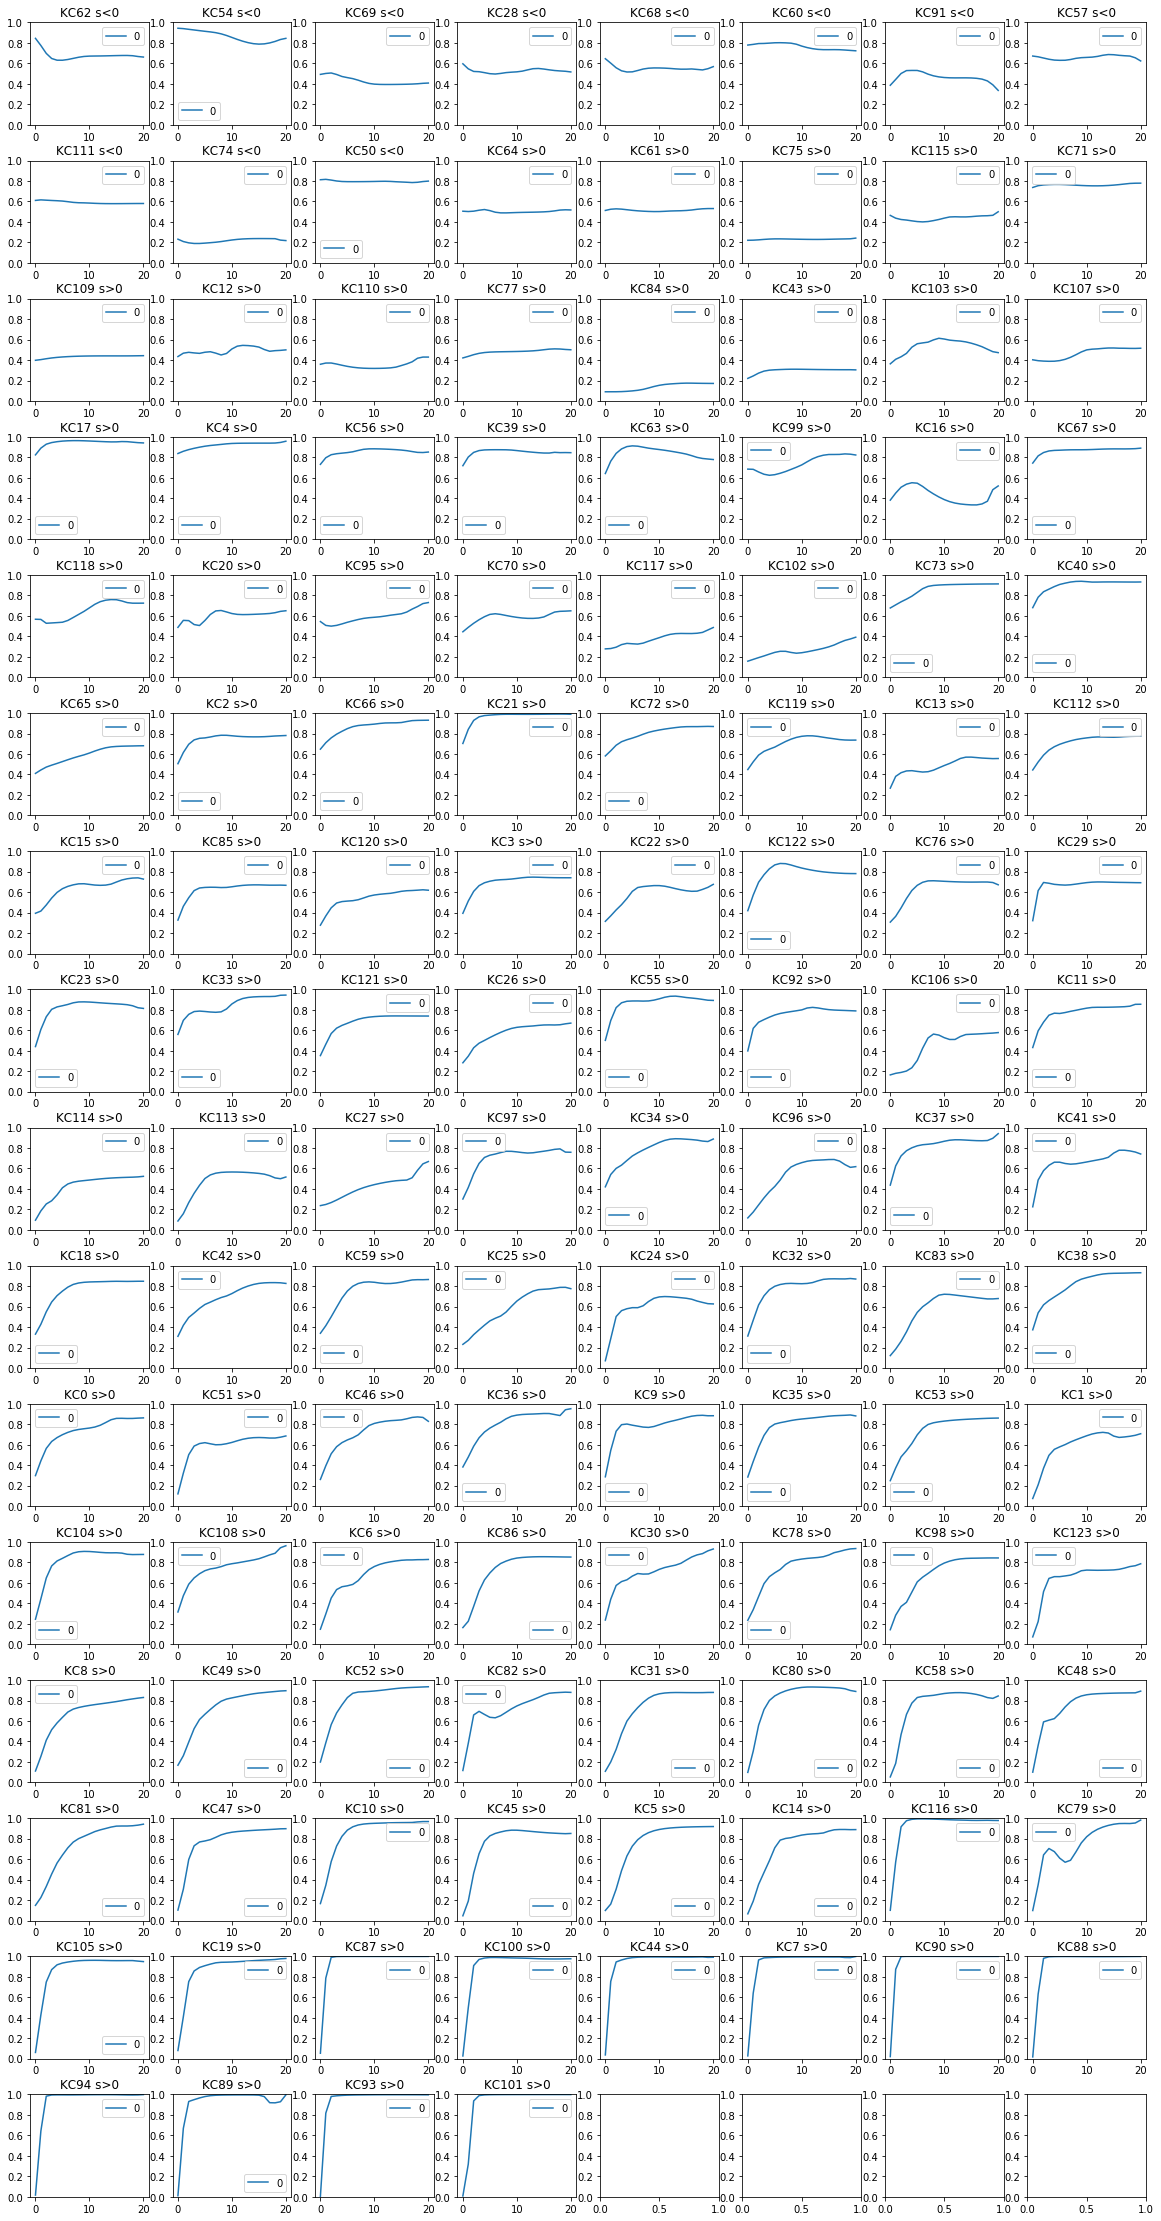

In [4]:
        
h, w = (124+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]<sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='0', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
ax.legend()
plt.show()

# Test auc (manual)

In [43]:
# pre straighten
pd.Series([0.796907,0.798236,0.79668,0.796917,0.795682]).describe()

count    5.000000
mean     0.796884
std      0.000910
min      0.795682
25%      0.796680
50%      0.796907
75%      0.796917
max      0.798236
dtype: float64

In [44]:
# no pre
pd.Series([0.795603,0.797074,0.795955,0.795035,0.795182]).describe()

count    5.000000
mean     0.795770
std      0.000814
min      0.795035
25%      0.795182
50%      0.795603
75%      0.795955
max      0.797074
dtype: float64

In [34]:
config_name = '20_0218_edm2020_assistments09'
expsoutdir = projectdir / 'output' / config_name

# config_path = sorted(projectdir / 'config' / experiment_name).iterdir())[0]
config_path = projectdir / 'config' / config_name / 'assistments09.json'
with open(config_path, 'r') as f:
    config_dict = json.load(f)
    config_dict['config_name'] = config_path.parent.name
    config_dict['exp_name'] = config_path.stem

def check_prev_report(config_name, exp_name, projectdir):
    reportdir = projectdir / 'output' / config_name / exp_name / 'report'
    checkpointdir = projectdir / 'output' / config_name / exp_name / 'checkpoints'
    if not reportdir.exists() or not checkpointdir.exists():
        return None
    report_path = sorted(reportdir.glob('*/*.json'))[-1]
    checkpoint_path = sorted(checkpointdir.glob('*/*.model'))[-1]
    return report_path, checkpoint_path

# load previously trained model
report_path, checkpoint_path = check_prev_report(config_path.parent.name, config_path.stem, projectdir)
with open(report_path, 'r') as f:
    report_dict = json.load(f)
config_dict = report_dict['config']
config_dict['load_model'] = str(checkpoint_path)
config = Config(config_dict, projectdir=projectdir)

trainer = Trainer(config)

INFO : 273 : 08:55 : ksdkt/assistments09 	| PyTorch: 1.3.0
INFO : 273 : 08:55 : ksdkt/assistments09 	| PyTorch: 1.3.0
INFO : 273 : 08:55 : ksdkt/assistments09 	| PyTorch: 1.3.0
INFO : 273 : 08:55 : ksdkt/assistments09 	| Using Device: cuda
INFO : 273 : 08:55 : ksdkt/assistments09 	| Using Device: cuda
INFO : 273 : 08:55 : ksdkt/assistments09 	| Using Device: cuda


In [8]:
report_dict['indicator']

{'epoch': {'0': [10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   110,
   120,
   130,
   140,
   150,
   160,
   170,
   180,
   190,
   200,
   210,
   220,
   230,
   240,
   250,
   260,
   270,
   280,
   290,
   300,
   310,
   320,
   330,
   340,
   350,
   360,
   370,
   380,
   390,
   400,
   410,
   420,
   430,
   440,
   450,
   460,
   470,
   480,
   490,
   500,
   510,
   520,
   530,
   540,
   550,
   560,
   570,
   580,
   590,
   600,
   610,
   620,
   630,
   640,
   650,
   660,
   670,
   680,
   690,
   700,
   710,
   720,
   730,
   740,
   750,
   760,
   770,
   780,
   790,
   800,
   810,
   820,
   830,
   840,
   850,
   860,
   870,
   880,
   890,
   900,
   910,
   920,
   930,
   940,
   950,
   960,
   970,
   980,
   990,
   1000],
  '1': [10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   110,
   120,
   130,
   140,
   150,
   160,
   170,
   180,
   190,
   200,
   210,
   220,
   230,
   240,
   25

In [108]:
config_name = '20_0218_edm2020_asmt0910'
report_straighten_pre0_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size0.auto', projectdir)
report_straighten_pre5_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size5.auto', projectdir)
report_straighten_pre10_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size10.auto', projectdir)
report_straighten_pre20_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size20.auto', projectdir)
report_straighten_pre50_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size50.auto', projectdir)
report_straighten_pre100_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size100.auto', projectdir)
report_straighten_pre150_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size150.auto', projectdir)
report_straighten_pre200_path, _ = check_prev_report(config_name, 'pre_dummy_epoch_size200.auto', projectdir)
with open(report_straighten_pre0_path, 'r') as f:
    report_straighten_pre0 = json.load(f)
with open(report_straighten_pre5_path, 'r') as f:
    report_straighten_pre5 = json.load(f)
with open(report_straighten_pre10_path, 'r') as f:
    report_straighten_pre10 = json.load(f)
with open(report_straighten_pre20_path, 'r') as f:
    report_straighten_pre20 = json.load(f)
with open(report_straighten_pre50_path, 'r') as f:
    report_straighten_pre50 = json.load(f)
with open(report_straighten_pre100_path, 'r') as f:
    report_straighten_pre100 = json.load(f)
with open(report_straighten_pre150_path, 'r') as f:
    report_straighten_pre150 = json.load(f)
with open(report_straighten_pre200_path, 'r') as f:
    report_straighten_pre200 = json.load(f)

In [114]:
def show_learning_curve(name, jack_up, idclist_dic, config, idc='eval_auc'):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x = np.transpose(np.array(list(idclist_dic['epoch'].values())))
    x = idclist_dic['epoch']['0'] * 5
    x = [i+jack_up for i in x]
    y = []
    for _y in idclist_dic[idc].values():
        y += _y
#         ax.plot(x, y, label=k.replace('_', ' '))
    sns.lineplot(x=x, y=y, label=name+':'+idc)
#     ax.legend()
#     ax.set_ylim(0., 1.)
#     plt.savefig(outdir / f'{config.model_name}_lc.png')

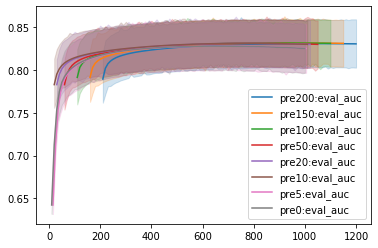

In [117]:
show_learning_curve('pre200', 200, report_straighten_pre200['indicator'], config)
show_learning_curve('pre150', 150, report_straighten_pre100['indicator'], config)
show_learning_curve('pre100', 100, report_straighten_pre100['indicator'], config)
show_learning_curve('pre50', 50, report_straighten_pre10['indicator'], config)
show_learning_curve('pre20', 20, report_straighten_pre10['indicator'], config)
show_learning_curve('pre10', 10, report_straighten_pre10['indicator'], config)
show_learning_curve('pre5', 5, report_straighten_pre0['indicator'], config)
show_learning_curve('pre0', 0, report_straighten_pre0['indicator'], config)
plt.show()

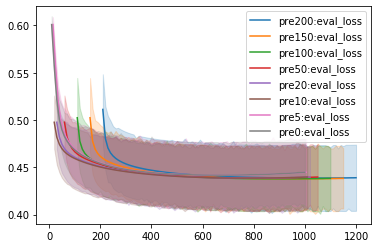

In [116]:
show_learning_curve('pre200', 200, report_straighten_pre200['indicator'], config, idc='eval_loss')
show_learning_curve('pre150', 150, report_straighten_pre100['indicator'], config, idc='eval_loss')
show_learning_curve('pre100', 100, report_straighten_pre100['indicator'], config, idc='eval_loss')
show_learning_curve('pre50', 50, report_straighten_pre10['indicator'], config, idc='eval_loss')
show_learning_curve('pre20', 20, report_straighten_pre10['indicator'], config, idc='eval_loss')
show_learning_curve('pre10', 10, report_straighten_pre10['indicator'], config, idc='eval_loss')
show_learning_curve('pre5', 5, report_straighten_pre0['indicator'], config, idc='eval_loss')
show_learning_curve('pre0', 0, report_straighten_pre0['indicator'], config, idc='eval_loss')
plt.show()

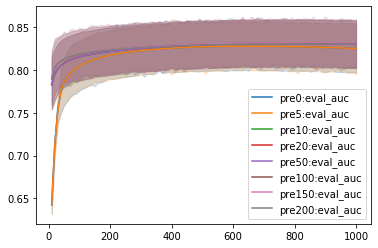

In [110]:
show_learning_curve('pre0', 0, report_straighten_pre0['indicator'], config)
show_learning_curve('pre5', 0, report_straighten_pre0['indicator'], config)
show_learning_curve('pre10', 0, report_straighten_pre10['indicator'], config)
show_learning_curve('pre20', 0, report_straighten_pre10['indicator'], config)
show_learning_curve('pre50', 0, report_straighten_pre10['indicator'], config)
show_learning_curve('pre100', 0, report_straighten_pre100['indicator'], config)
show_learning_curve('pre150', 0, report_straighten_pre100['indicator'], config)
show_learning_curve('pre200', 0, report_straighten_pre200['indicator'], config)
plt.show()

# Test auc

In [70]:
# no pre
s = pd.Series([0.795603,0.797074,0.795955,0.795035,0.795182])
print('no pre', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')
# s.describe()

no pre	0.795770±0.000814


In [71]:
# pre 10 straighten
s = pd.Series([0.796907,0.798236,0.79668,0.796917,0.795682])
print('pre 10', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

pre 10	0.796884±0.000910


In [101]:
# pre 0 straighten
s = pd.Series([f for f in report_straighten_pre0['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre0['indicator']['test_auc'].values()])
print('pre 0', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	662.0±52.6
pre 0	0.795809±0.000722


In [102]:
# pre 5 straighten
s = pd.Series([f for f in report_straighten_pre5['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre5['indicator']['test_auc'].values()])
print('pre 5', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	698.0±49.7
pre 5	0.797282±0.001265


In [103]:
# pre 10 straighten
s = pd.Series([f for f in report_straighten_pre10['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre10['indicator']['test_auc'].values()])
print('pre 10', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	760.0±57.0
pre 10	0.798472±0.000631


In [104]:
# pre 20 straighten
s = pd.Series([f for f in report_straighten_pre20['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre20['indicator']['test_auc'].values()])
print('pre 20', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	710.0±75.2
pre 20	0.797682±0.000751


In [105]:
# pre 50 straighten
s = pd.Series([f for f in report_straighten_pre50['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre50['indicator']['test_auc'].values()])
print('pre 50', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	750.0±30.8
pre 50	0.797701±0.001004


In [106]:
# pre 100 straighten
s = pd.Series([f for f in report_straighten_pre100['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre100['indicator']['test_auc'].values()])
print('pre 100', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	842.0±69.8
pre 100	0.798184±0.000904


In [111]:
# pre 150 straighten
s = pd.Series([f for f in report_straighten_pre150['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre150['indicator']['test_auc'].values()])
print('pre 150', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	816.0±72.3
pre 150	0.798445±0.000214


In [107]:
# pre 200 straighten
s = pd.Series([f for f in report_straighten_pre200['best']['auc_epoch'].values()])
print('best epoch', end='\t')
print(f'{s.mean():.1f}±{s.std():.1f}')
s = pd.Series([f[0] for f in report_straighten_pre200['indicator']['test_auc'].values()])
print('pre 200', end='\t')
print(f'{s.mean():.6f}±{s.std():.6f}')

best epoch	840.0±54.8
pre 200	0.797828±0.000651
